# Cryptocurrency price prediction using LSTMs | TensorFlow for Hackers (Part III)
Based on [this](https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f) tutorial  
Also on [google colab](https://colab.research.google.com/drive/1wWvtA5RC6-is6J8W86wzK52Knr3N1Xbm#scrollTo=VBXq-Wb_K1XR)

In [3]:
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install pandas
!pip install seaborn
!pip install pylab
!pip install matplotlib
!pip install sklearn
!pip install keras

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0
ERROR: Could not find a version that satisfies the requirement pylab (from versions: none)
ERROR: No matching distribution found for pylab
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=dcb581ec9700e32379db9c6d9ca7f617f98ec6e3462ee

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, CuDNNLSTM
from keras.layers import LSTM
from keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [5]:
# Check for GPU
tf.config.list_physical_devices('GPU') 

2022-09-12 04:25:33.132071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 04:25:33.228887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 04:25:33.229551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"
csv_path = "http://t.tmy.io/ETH-USD.csv"

In [7]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [8]:
df = df.sort_values('Date')

In [9]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [10]:
df.shape

(1737, 7)

Text(0, 0.5, 'Close Price (USD)')

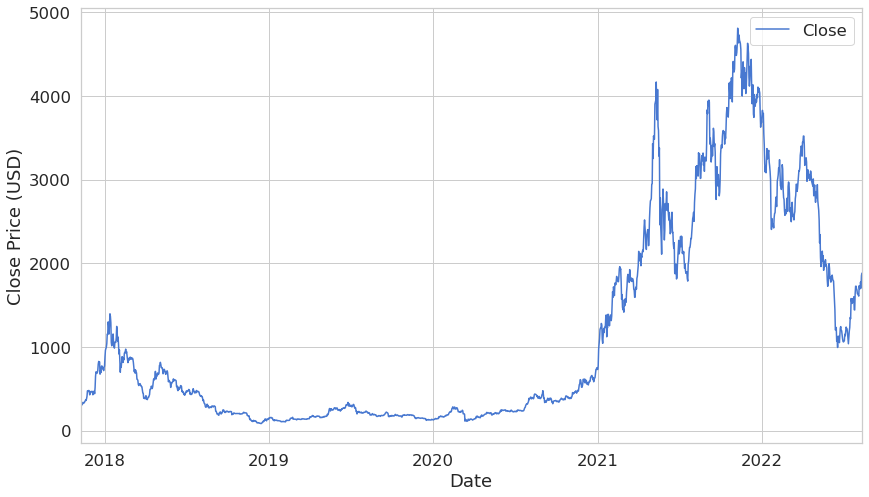

In [11]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [12]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [13]:
print(df.Close.values)
close_price = df.Close.values.reshape(-1, 1)

[ 320.884003  299.252991  314.681    ... 1703.025024 1851.742676
 1882.390381]


In [14]:
scaled_close.shape

(1737, 1)

In [15]:
np.isnan(scaled_close).any()

False

In [16]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [17]:
scaled_close = scaled_close.reshape(-1, 1)

In [18]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [19]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [20]:
X_train.shape

(1555, 99, 1)

In [21]:
X_test.shape

(82, 99, 1)

# Model

In [22]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

2022-09-12 04:26:00.021767: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-12 04:26:00.022785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 04:26:00.023522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 04:26:00.024129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Training

In [23]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [26]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
22/22 [==============================] - 5s 53ms/step - loss: 0.0330 - val_loss: 0.0729
Epoch 2/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0510 - val_loss: 0.0214
Epoch 3/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0356 - val_loss: 0.0088
Epoch 4/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0215 - val_loss: 0.0155
Epoch 5/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0112 - val_loss: 0.0032
Epoch 6/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0284 - val_loss: 0.0271
Epoch 7/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0464 - val_loss: 0.0986
Epoch 8/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0367 - val_loss: 0.0334
Epoch 9/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0161 - val_loss: 0.0025
Epoch 10/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0174 - val_loss: 0.0063
Epoch 11/

In [27]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 26ms/step - loss: 0.0011


0.0010978105710819364

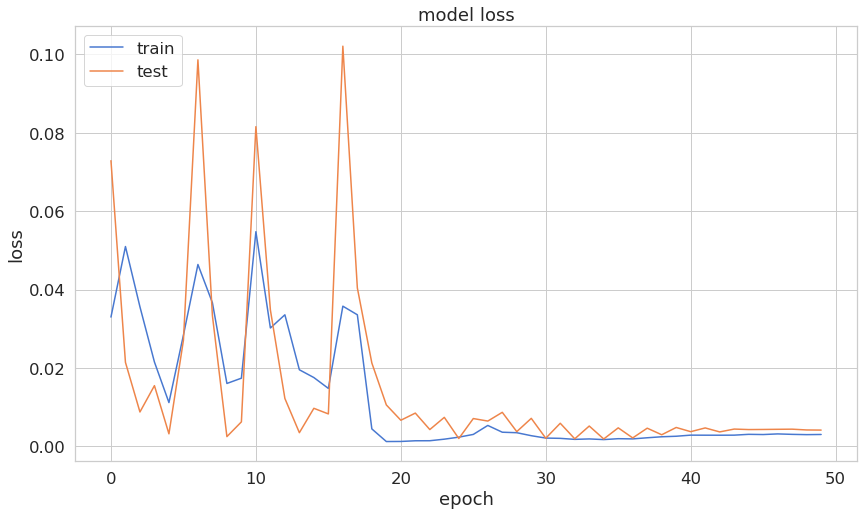

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

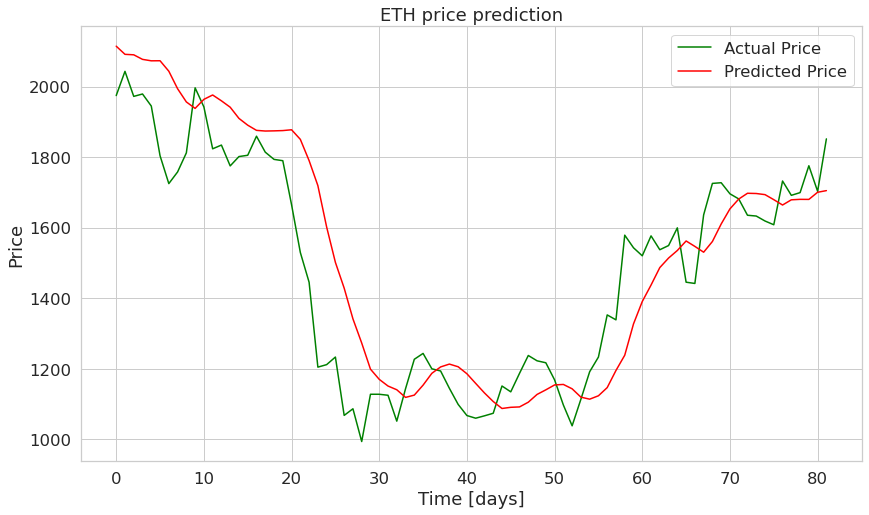

In [33]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('ETH price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()